# **Predicción del precio del oro**

En este cuaderno se construirá un modelo de datos secuenciales para la predicción del precio del oro

In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available


## **Importamos las librerías**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

## **Leyendo el dataset**

El dataset lo puedes encontrar en:  

https://www.kaggle.com/datasets/farzadnekouei/gold-price-10-years-20132023

In [6]:
df = pd.read_csv('/content/Gold Price (2013-2023).csv')

## **Vistaso del dataset**

In [7]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


## **Información básica del dataset**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


## **Selección de características**

Las variables de Vol. y Change % no las necesitamos para la predicción del rpecio del oro, por lo que procederemos a eliminarlas

In [9]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

Ahora vamos a transformar los datos a datos de tiempo

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

Vamos a eliminar las comas "," del dataset y convertiremos los datos numéricos a fotantes

In [11]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

Ahora nuesto dataset se ve así:

In [12]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


## **Verificamos que no haya datos duplicados**

In [13]:
df.duplicated().sum()

0

## **Verificamos que no haya datos nulos**

In [14]:
df.isnull().sum().sum()

0

## **Ahora visualizaremos los datos**

In [15]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='green')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(1,1,1,0.9)')

## **Dividiendo el dataset**

La división para el entrenamiento en datos de tiempo es diferente a como lo venías realizando. Aqui no podemos dividir los datos de manera aleatoria porque terminaríamos entrenando en datos futuros.  

El conjunto de prueba se compone por datos posteriores a los datos de entrenamiento. Consideraremos los datos del 2022 como datos de prueba.

In [16]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

Ahora graficaremos los datos de entrenamiento con los datos de prueba

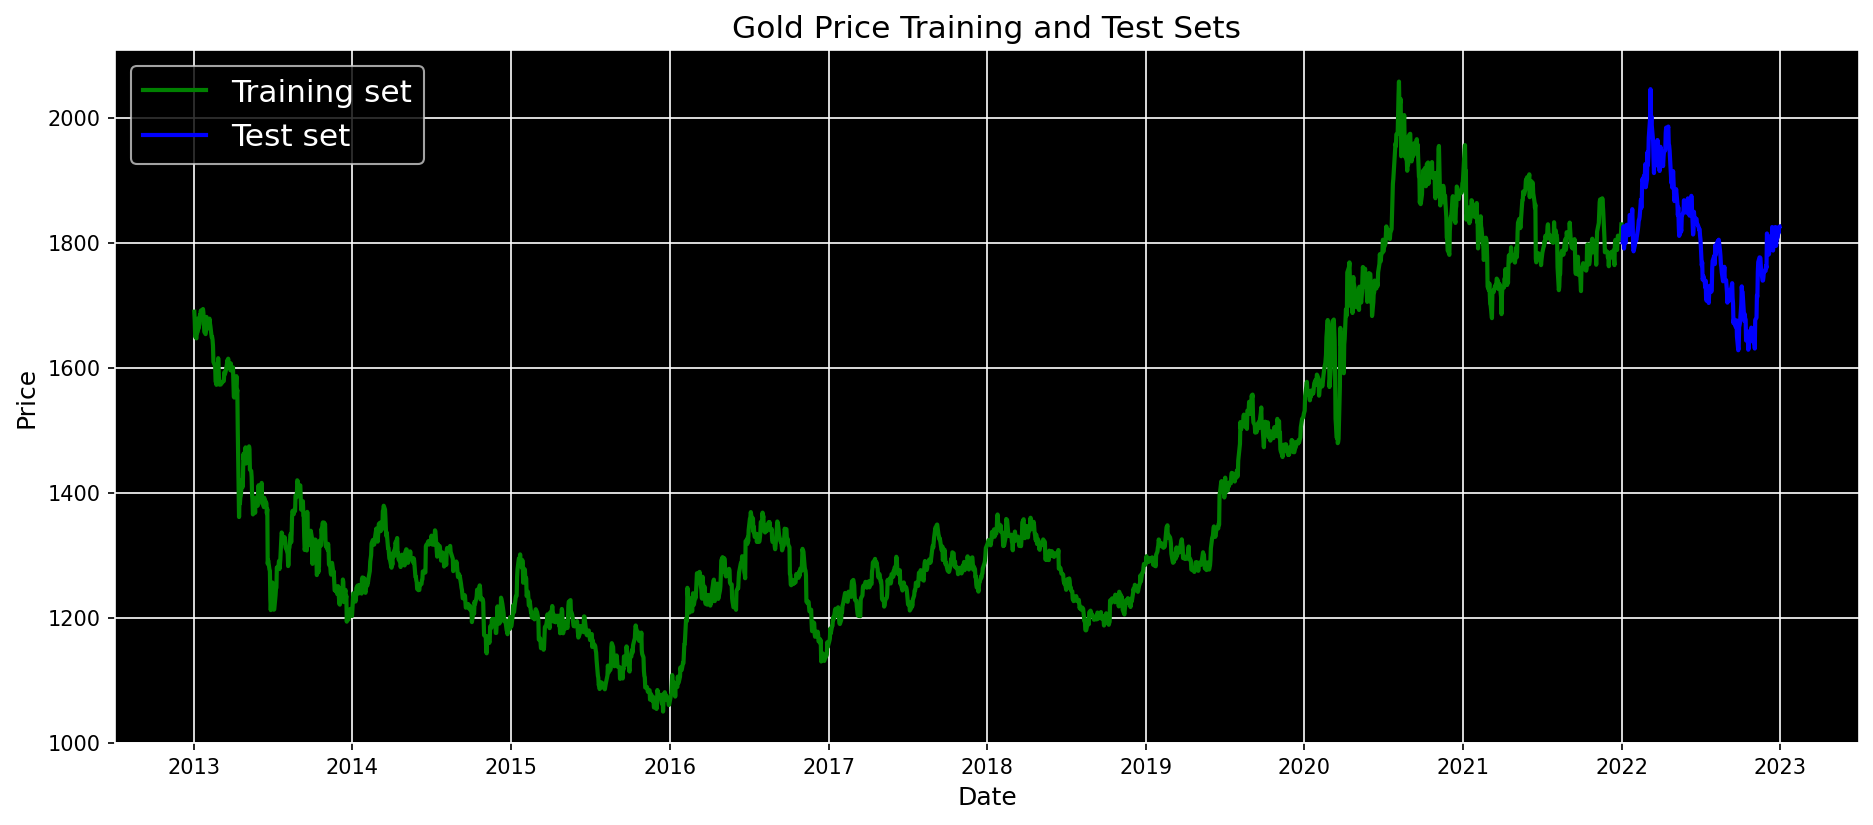

In [17]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = ('black')
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='green', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15}, labelcolor="white")
plt.grid(color='white')
plt.show()

## **Escalado**

Para reducir el costo computacional, procederemos a escalar los datos

In [18]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

## **Re estructuración de los datos**

El uso de pasos de tiempo previos para predecir el siguiente paso de tiempo se denomina ventana deslizante. De esta manera, los datos de series temporales pueden expresarse como aprendizaje supervisado. Podemos hacerlo utilizando los pasos de tiempo anteriores como variables de entrada y el siguiente paso de tiempo como la variable de salida. El número de pasos de tiempo previos se le llama "el ancho de la ventana". Aquí establecemos el ancho de la ventana en 60. Por lo tanto, X_train y X_test serán listas anidadas que contienen listas de 60 precios en intervalos de tiempo. y_train y y_test también son listas de precios del oro que contienen el precio del oro del día siguiente correspondiente a cada lista en X_train y X_test, respectivamente.

In [19]:
window_size = 60

### **Conjunto de entrenamiento** *texto en cursiva*

In [20]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [21]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

### **Conjunto de Prueba**

In [22]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [23]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

## **Conversión de los datos a arreglos Numpy**

In [24]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [26]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60, 1)
y_train Shape:  (2263, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


## **Construcción de la red LSTM**

Se construirá una red LSTM la cual es una red neuronal recurrente

**Definición del modelo**

In [27]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

## **Entrenamiento**

In [28]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0633 - val_loss: 0.0605
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0111 - val_loss: 0.0282
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0071 - val_loss: 0.0121
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 12/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

## **Evaluación del modelo**

Utilizaremos la métrica MAPE (Mean Absolute Percentage Error) para evaluar nuestro sistema de predicción

In [29]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6082e-04 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [30]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [31]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.000648097658995539
Test MAPE: 0.026673497662813375
Test Accuracy: 0.9733265023371866


## **Visualización de los resultados**

In [32]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

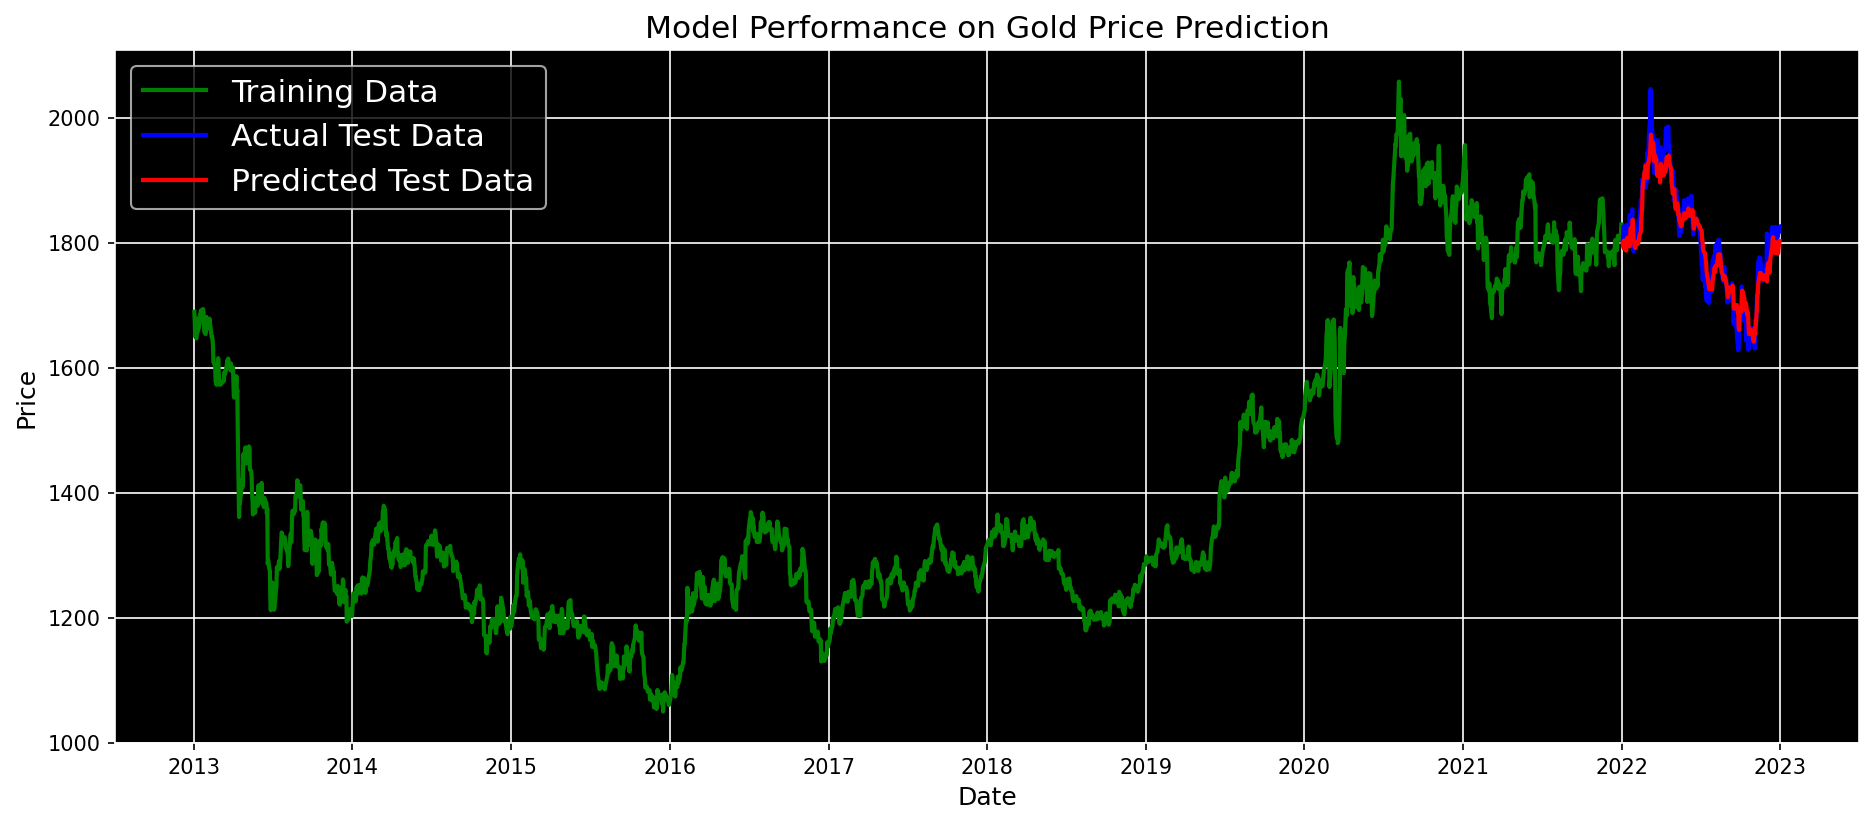

In [33]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'black'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='green', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15}, labelcolor="white")
plt.grid(color='white')
plt.show()